In [367]:
import numpy as np
import operator
import time
import matplotlib.pyplot as plt
from scipy.spatial import distance
from matplotlib.patches import Rectangle

In [71]:
points_dataset=np.loadtxt('./dataset/dataset/twitter_1000000.txt')

In [82]:
def get_distance(x,y):
    return np.sqrt(np.sum((x-y)**2))

def static_clustering(points,free_points,k,r,z):
    disks={}
    expanded_disks={}
    inverse_disks={}
    inverse_expanded_disks={}
    centers=[]
    distances=distance.cdist(points[free_points,:], points[free_points,:], 'euclidean')
    
    for i in range(0,len(free_points)):
        expanded_disks[i]=np.argwhere(distances[i]<3*r).reshape(-1).tolist()
        disks[i]=np.argwhere(distances[i]<r).reshape(-1).tolist()
        for j in expanded_disks[i]:
            if j not in inverse_expanded_disks:
                inverse_expanded_disks[j]=[i]
            else:
                inverse_expanded_disks[j].append(i)
        for j in disks[i]:
            if j not in inverse_disks:
                inverse_disks[j]=[i]
            else:
                inverse_disks[j].append(i)
    nb_covered_points=0
    points_covered=[]
    for i in range(0,min(k,len(free_points))):
        max_index=max(disks, key=lambda x:len(disks[x]))
        centers.append(max_index)
        nb_covered_points+=len(expanded_disks[max_index])
        points_covered+=expanded_disks[max_index]
        for j in expanded_disks[max_index]:
            for f in inverse_disks[j]:
                disks[f].remove(j)
            for f in inverse_expanded_disks[j]:
                if f!=max_index:
                    expanded_disks[f].remove(j)
        del disks[max_index]
        del expanded_disks[max_index]
    if z>=len(free_points)-nb_covered_points:
        return [free_points[i] for i in centers]
    else:
        return False

In [208]:
# streaming algorithm

def step_1(i,clusters_centers,free_points,r,new_batch=False):
#     print("step1")
    if new_batch:
        free_points+=[j for j in range(i,i+batch_size) if j<len(points)]
#     print("#free points",len(free_points))
    for center in clusters_centers.keys():
        for j in free_points:
            if get_distance(points[center],points[j])<=nu*r:
                free_points.remove(j)
#     print("#free points",len(free_points))
    return free_points

def step_2(free_points,clusters_centers,r):
#     print("step2")
    distances=distance.cdist(points[free_points,:], points[free_points,:], 'euclidean')
    tmp=np.sum(distances <= beta*r, axis=1)
    tmp=[[tmp[j],free_points[j],j] for j in range(0,len(tmp)) if tmp[j]>=z+1]
#     print("#tmp",len(tmp))
    if len(tmp)>0:
        tmp_sorted=sorted(tmp,key=lambda x:x[0],reverse=True)
        cluster_center=tmp_sorted[0][2]
        support_points=[free_points[j] for j in range(distances.shape[1]) if distances[cluster_center,j]<= beta*r]
        clusters_centers[free_points[cluster_center]]=support_points
#         print("cluster center",cluster_center,len(support_points))
        return dict(clusters_centers)
    return "step3"
    
def step_3(free_points,clusters_centers,r):
#     print("step3")
    l=len(clusters_centers)
    check=(l<=k and len(free_points)<=(k-l)*z+z)
#     print(check,"#free points",len(free_points),l<=k,len(free_points)<=(k-l)*z+z)
    if k-l==0 and len(free_points)<z:
        return []
    if len(free_points)<=k:
        return []
    
    centers=static_clustering(points,free_points,k-l,nu*r,z)
#     print("centers",centers)
    if centers!=False and check:
        return centers
    return "step4"
    
def step_4(clusters_centers,r):
#     print("step4")
    r*=alpha
    print("r=",r)
    keys=list(clusters_centers.keys())    
    
    intersections=[]
    for i in range(len(keys)):
        for j in range(i+1,len(keys)-1):
            intersections.append([i,j,len([value for value in clusters_centers[keys[i]] if value in clusters_centers[keys[j]]])])
    
    intersections=sorted(intersections,key=lambda x:x[2],reverse=True)
    
    for i in intersections:
        if keys[i[0]] in clusters_centers and keys[i[1]] in clusters_centers:
            cluster_a=clusters_centers[keys[i[0]]]
            cluster_b=clusters_centers[keys[i[1]]]
            distances=distance.cdist(points[cluster_a,:], points[cluster_b,:], 'euclidean')
            if np.any(distances<=2*alpha*r):
                del clusters_centers[keys[i[1]]]
#                 print("delete center",keys[i[1]])
    return clusters_centers,r

In [401]:
# main

i=0
np.random.seed(1)
k=20
# z=30
alpha=4
beta=8
nu=16
m=1
optimal_list=[]
z_list=[10,20,30,40,50]
time_list=[]
radius_begining_list=[]
radius_end_list=[]

for z in z_list:
    i=0
    np.random.seed(1)
    k=20
    alpha=4
    beta=8
    nu=16
    m=1
    batch_size=k*z
    points=points_dataset[:,1:]
    distances=distance.cdist(points[:k+z+1,:], points[:k+z+1,:], 'euclidean')
    r=np.min(distances[(np.ones((len(distances),len(distances)))-np.eye(len(distances))).astype(bool)])/2
    clusters_centers={}
    keep_points_indices=[]
    free_points=[]
    new_batch=True

    good_result=[]
    a=time.time()
    radius_begining_list.append(r*nu)
    while True:
    #     print(i,r,len(clusters_centers))
    #     print('i',i)
        free_points=step_1(i,clusters_centers,free_points,r,new_batch=new_batch)
        step_2_result=step_2(free_points,clusters_centers,r)
        if step_2_result=="step3":
            static_result=step_3(free_points,clusters_centers,r)
            if static_result=="step4":
    #             if np.floor(r)==2:
    #                 break
                clusters_centers,r=step_4(clusters_centers,r)
                new_batch=False
                continue
            else:
                good_result=static_result.copy()
                if i>=len(points)-batch_size-1:
                    break
                i+=batch_size
                new_batch=True
    #             print("static_result",static_result)
                continue
        else:
            new_batch=False
    #         print(clusters_centers)
            clusters_centers=step_2_result
            continue
    b=time.time()
    radius_end_list.append(r*nu)
    time_list.append(b-a)
    
    size=20000
    distances=distance.cdist(points[:size,:], points[:size,:], 'euclidean')
    tmp=np.argwhere(distances==np.max(distances))[0]
    centers=[tmp[0],tmp[1]]
    while len(centers)<k+z+1:
        dist=distance.cdist(points[:size,:], points[centers,:], 'euclidean')
        tmp=np.argsort(np.min(dist,axis=1)).tolist()
        for i in reversed(tmp):
            if i not in centers:
                centers.append(i)
                break
    distances=distance.cdist(points[centers,:], points[centers,:], 'euclidean')
    q=np.min(distances[(np.ones((len(distances),len(distances)))-np.eye(len(distances))).astype(bool)])
    optimal_list.append(q)
    print()
    print()

r= 0.23600141565825594
r= 0.9440056626330238
r= 3.776022650532095
r= 15.10409060212838


r= 0.23600141565825594
r= 0.9440056626330238
r= 3.776022650532095


r= 0.23600141565825594
r= 0.9440056626330238
r= 3.776022650532095


r= 0.23600141565825594
r= 0.9440056626330238
r= 3.776022650532095


r= 0.23600141565825594
r= 0.9440056626330238
r= 3.776022650532095




In [337]:
size=20000
distances=distance.cdist(points[:size,:], points[:size,:], 'euclidean')
tmp=np.argwhere(distances==np.max(distances))[0]
centers=[tmp[0],tmp[1]]
while len(centers)<k+z+1:
    dist=distance.cdist(points[:size,:], points[centers,:], 'euclidean')
    tmp=np.argsort(np.min(dist,axis=1)).tolist()
    for i in reversed(tmp):
        if i not in centers:
            centers.append(i)
            break

In [338]:
plt.scatter(points[10000:20000,0],points[10000:20000,1],c="b")
plt.scatter(points[centers,0],points[centers,1],c="r")
plt.show()

In [339]:
distances=distance.cdist(points[centers,:], points[centers,:], 'euclidean')
np.min(distances[(np.ones((len(distances),len(distances)))-np.eye(len(distances))).astype(bool)])

31.9245277817025

In [111]:
plt.plot(z_list,time_list,label="Time (s)")
# plt.plot(z_list,radius_begining_list)
plt.plot(z_list,radius_end_list,label="Radius")
plt.xlabel("z")
plt.legend()
plt.show()

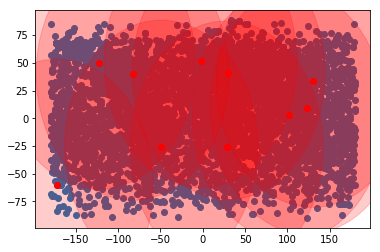

In [355]:
qq=list(clusters_centers.keys())+static_result#+free_points
fig, ax = plt.subplots()
ax.scatter(points[:,0],points[:,1])
plt.scatter(points[qq,0],points[qq,1],c="red")
for i in qq:
    circle=plt.Circle((points[i,0],points[i,1]),r*nu, color='r',alpha=0.2)
    ax.add_artist(circle)

# count_rectangle=0
# step=26*2   
# for x in range(int(np.min(points[:,0])),int(np.max(points[:,0])),step):
#     for y in range(int(np.percentile(points[:,1],0.005)),int(np.max(points[:,1])),step):
#         rect = Rectangle((x,y),step,step,linewidth=1,edgecolor='r',facecolor='none')
#         ax.add_patch(rect)
# #         circle=plt.Circle((x+step/2,y+step/2),np.sqrt(2)*step/2, color='r',alpha=0.2)
# #         ax.add_artist(circle)
#         count_rectangle+=1
# print(count_rectangle,np.sqrt(2)*30)
# ax.set_xlabel("Longitude")
# ax.set_ylabel("Latitude")
plt.show()